# Update the value of overscan for ITL chips

Use the contents of `AOS_segmentation` notebook which was used before to do that... 


Also,  there are two scripts: 
    
    
    update_segmentation_comcam.py
    
and 
    
    update_segmentation_lsst.py 
    
as well as 


    updatePhosimFunctions.py


In [1]:
import updatePhosimFunctions as up
from lsst.obs.lsst import LsstCam
import numpy as np 

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [76]:
import os
# read all the lines to a list : 
path = '/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/phosim_syseng4/data/lsst/'
fname = 'segmentation.txt'
pathToFile = os.path.join(path,fname)

# read the content of segmentation.txt file
# and store in a  dictionary
headerLines, contentLines = up.readFile(pathToFile)
sensorData = up.storeSensorDataAsDictionary(contentLines)

# initialize the camera 
camera = LsstCam().getCamera()
    
# Update the data 
newSensorData  = {}
  

In [77]:
for sensorName in list(sensorData.keys()):

    detector = camera.get(sensorName)
    
    print(sensorName, detector.getPhysicalType())

    newSensorData[sensorName] = []
    
    for content in sensorData[sensorName]:
        splitContent = content.split() # by default splits by whitespace, omitting empty strings 
        newSplitContent = splitContent.copy()
        
        if len(content)<40:
            # print old sensor px_x, px_y 
            # vs mapper one ... 
            bbox = detector.getBBox()
            px_y = bbox.getDimensions()[0]
            px_x = bbox.getDimensions()[1]
            old_px_x = splitContent[2]
            old_px_y = splitContent[3]

            if old_px_x !=  str(px_x) : 
                print(sensorName, 'px_x,px_y different', old_px_x, old_px_y,  '--> ', sensorName, px_x, px_y)
            
        if len(content)>40:            
            sensorAmpName = splitContent[0]
            ampName = sensorAmpName.split('_')[2]
            ampGain = splitContent[7]
            ampBias  = splitContent[9]
            ampReadNoise = splitContent[11]
            ampDarkCurrent = splitContent[13]

            #
            # begin loop lsstCam mapper amp info 
            #
            # read the lsstCam information for that sensor / amp ... 
            for amp in detector:
                if amp.getName() == ampName:
                    
                    # check whether gain, readNoise, bias, dark current are all the same 
                    lsstGain = str(amp.getGain())
                    if ampGain != lsstGain:
                        print(f'gain phosim: {ampGain}, lsstMapper: {lsstGain}')
                        newSplitContent[7] = lsstGain
                    # bias not stored in the amplifier 
                    
                    lsstReadNoise = str(amp.getReadNoise()) 
                    if ampReadNoise != lsstReadNoise:
                        print(f'read noise phosim: {ampReadNoise}, lsstMapper: {lsstReadNoise}')
                        newSplitContent[11] = lsstReadNoise
 
                    # dark current not stored in amplifier
                    
        
                    # check xlo, xhi, ylo, yhi ...
                    # amp.getBBox() is the only one that explains the extent of the amplifier 
                    # in sensor  coords ... 
                    bbox = amp.getBBox()

                    # here I assign them to match the phoSim Transposed system 
                    xlo = bbox.getMinY()
                    xhi = bbox.getMaxY()
                    ylo = bbox.getMinX()
                    yhi = bbox.getMaxX()
                    
                    #print(amp.getName(), xlo,xhi,ylo,yhi)
                    xlo_old = splitContent[1]
                    xhi_old = splitContent[2]
                    ylo_old = splitContent[3]
                    yhi_old = splitContent[4]
                    
                    if str(xlo) != xlo_old : 
                        print(xlo, xlo_old)
                        
                    if  str(xhi) != xhi_old : 
                        print(xhi, xhi_old)
                        
                    if str(ylo) != ylo_old : 
                        print(ylo, ylo_old)
                        
                    if  str(yhi) != yhi_old : 
                        print(yhi, yhi_old)  
                        


                    # update the overscan / prescan values 
                    # preserving here phosim's rotation of 
                    # 90 degrees to the left wrt lsstCam ... 
                    
                    #      phosim        < ---        lsstCam 
                    #
                    # serial overscan              parallel prescan
                    # serial prescan               parallel overscan
                    # parallel overscan            serial overscan
                    # parallel prescan             serial prescan 
                    
                    # eg.      3             0            10            10 
                    #     parallel pre | serial over | serial pre | parallel over 
                    #          A             B            C              D 
                    
                    # ITL      3             0            48            32
                    # E2V     10             0            46            54
                    
                    # these numbers can be achieved from :
                    oldA, oldB, oldC, oldD = splitContent[15], splitContent[16], splitContent[17], splitContent[18]
                    
                    bbox = amp.getRawSerialPrescanBBox()
                    A = bbox.getWidth()
                    
                    B = '0'

                    bbox = amp.getRawParallelOverscanBBox()
                    C = bbox.getHeight()

                    bbox = amp.getRawSerialOverscanBBox()
                    D = bbox.getWidth()
                    #print(oldA, oldB, oldC, oldD, A,B,C,D)
                    
                    if oldA != str(A):
                        newSplitContent[15] = str(A) # parallel prescan for phosim
                        print(f'{ampName} updating {oldA} --> {A}')
                    if oldB != B:
                        newSplitContent[16] = '0'
                        print(f'{ampName} updating {oldB} --> {B}')
                    if oldC != str(C):
                        newSplitContent[17] = str(C) # serial prescan for phosim
                        print(f'{ampName} updating {oldC} --> {C}')
                    if oldD != str(D):
                        newSplitContent[18] = str(D) # parallel overscan for phosim 
                        print(f'{ampName} updating {oldD} --> {D}')
                      
        # either way, make new content by joining the elements of 
        # the updated split content: 
        newContent = ' '.join(newSplitContent)+'\n'
        #print(newContent)
        
        
        # add the new content line to the new dictionary 
        newSensorData[sensorName].append(newContent)

R00_SG0 ITL_G
C00 updating 32 --> 64
C01 updating 32 --> 64
C02 updating 32 --> 64
C03 updating 32 --> 64
C04 updating 32 --> 64
C05 updating 32 --> 64
C06 updating 32 --> 64
C07 updating 32 --> 64
C10 updating 32 --> 64
C11 updating 32 --> 64
C12 updating 32 --> 64
C13 updating 32 --> 64
C14 updating 32 --> 64
C15 updating 32 --> 64
C16 updating 32 --> 64
C17 updating 32 --> 64
R00_SG1 ITL_G
C00 updating 32 --> 64
C01 updating 32 --> 64
C02 updating 32 --> 64
C03 updating 32 --> 64
C04 updating 32 --> 64
C05 updating 32 --> 64
C06 updating 32 --> 64
C07 updating 32 --> 64
C10 updating 32 --> 64
C11 updating 32 --> 64
C12 updating 32 --> 64
C13 updating 32 --> 64
C14 updating 32 --> 64
C15 updating 32 --> 64
C16 updating 32 --> 64
C17 updating 32 --> 64
R00_SW1 ITL_WF
C17 updating 32 --> 64
C16 updating 32 --> 64
C15 updating 32 --> 64
C14 updating 32 --> 64
C13 updating 32 --> 64
C12 updating 32 --> 64
C11 updating 32 --> 64
C10 updating 32 --> 64
R00_SW0 ITL_WF
C17 updating 32 --> 64

In [81]:
ticket  = 'DM-37218'

# combine the new content as a long list of lines 
newContentLines = []
for sensorName in newSensorData.keys():
    for line in newSensorData[sensorName]:
        newContentLines.append(line)
        
# write the unchanged header, and the new content,
# into a new segmentation.txt file 
fname = f"segmentation_{ticket}.txt"
fpath = os.path.join(path,fname)
f = open(fpath, "w")
f.writelines(headerLines)
f.writelines(newContentLines)
f.close()      
print('Saved as %s'%fpath)

Saved as /sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/phosim_syseng4/data/lsst/segmentation_DM-37218.txt


Once `git status` finishes indexng, run  via slurm :
    
    cd DM-37218
    cp ../DM-37063/runSlurmVig.sl .
    cp ../DM-37063/
    
    nano runSlurm.sl
    
and put

    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 200 --boresightDeg 0.0 0.0 --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-37218/imgCloseLoop_skyRefCat_new_seg/ --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/skyRefCat_format.txt
    
    
It's stuck in a queue...




INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


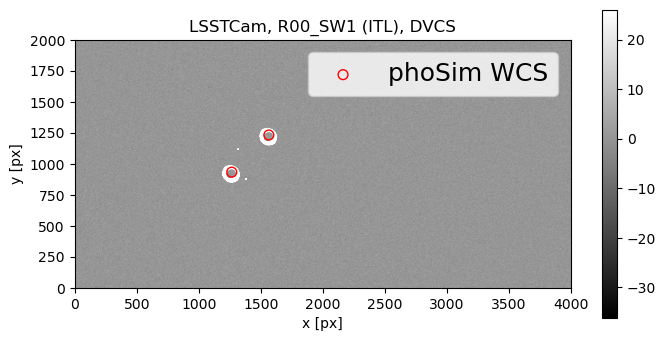

In [1]:
import run_ps1_functions as func

repoDir = '/sdf/data/rubin/u/scichris/WORK/AOS/DM-37218/imgCloseLoop_skyRefCat_new_seg/phosimData/'
func.plot_butler_with_wcs(repoDir, detector="R00_SW1",
    inst_file='/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_wep/tests/testData/skyRefCat.txt',
    coords='DVCS',
    collections=['ts_phosim_9006000'],
    xmax=2000, ymax=4000,xsize=8,ysize=4
                         )

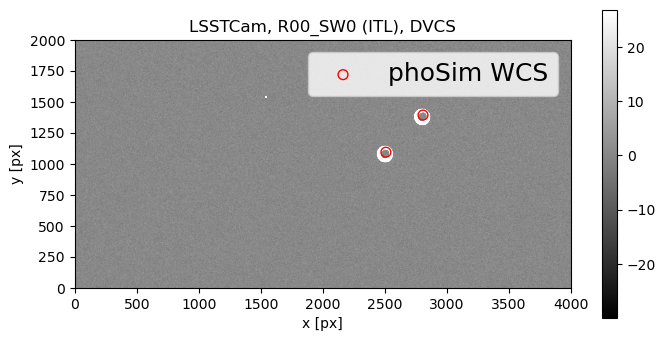

In [2]:
func.plot_butler_with_wcs(repoDir, detector="R00_SW0",
    inst_file='/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_wep/tests/testData/skyRefCat.txt',
    coords='DVCS',
    collections=['ts_phosim_9006000'],
    xmax=2000, ymax=4000,xsize=8,ysize=4
                         )

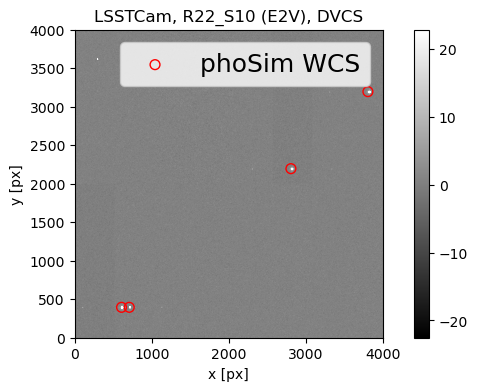

In [4]:
func.plot_butler_with_wcs(repoDir, detector="R22_S10",
    inst_file='/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_wep/tests/testData/skyRefCat.txt',
    coords='DVCS',
    collections=['ts_phosim_9006000'],
    xmax=4000, ymax=4000,xsize=8,ysize=4
                         )

In [5]:
import algoritm_functions as func

repo_dir = '/sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'

detectorDonutsExtra = {}
detectorDonutsIntra = {}

for sensor in ['R00','R04','R40','R44']:

    # read in all the donuts 
    donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repoDir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)

    detectorDonutsExtra[sensor] = donutStampsExtra
    detectorDonutsIntra[sensor] = donutStampsIntra


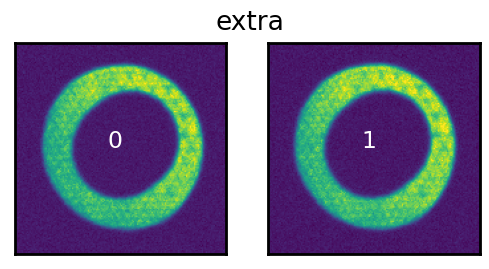

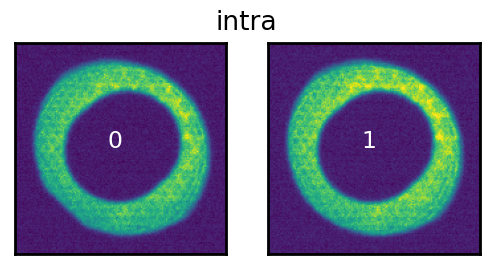

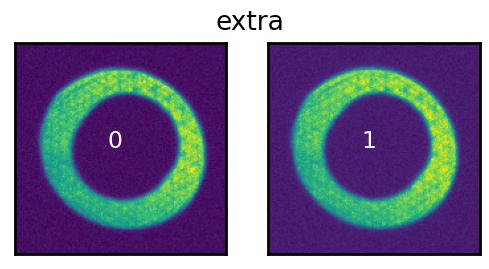

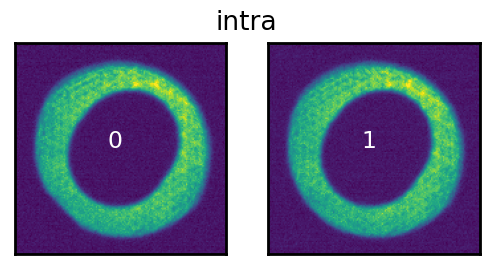

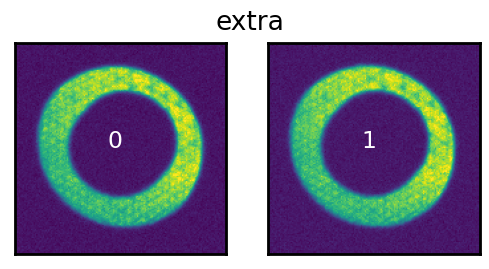

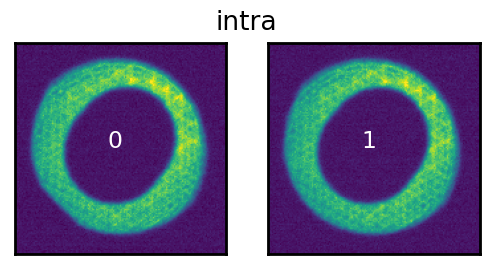

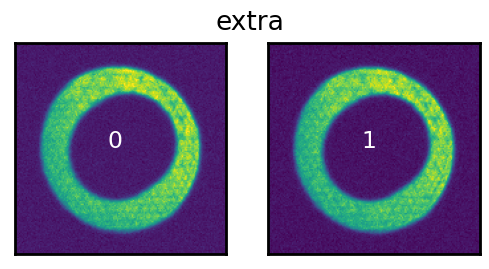

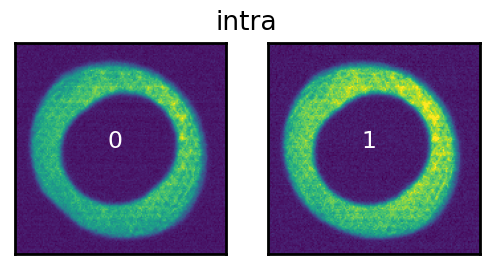

In [6]:

for sensor in ['R00','R04','R40','R44']:
    donutStamps = detectorDonutsExtra[sensor]
    func.plot_stamps( donutStamps, 'extra', N=len(donutStamps), 
                panel_width=3)
    
    donutStamps = detectorDonutsIntra[sensor]
    func.plot_stamps( donutStamps, 'intra', N=len(donutStamps), 
                panel_width=3)
    

Ok, so the new `segmentation` works fine, including the convergence (and now there is no message about `
lsst.obs.lsst.assembly WARNING`).

**Before segmentation update**:
    
    
    WORK/AOS/DM-37063/slurm-1405784.out : 
    
    ...
    lsst.defineVisits INFO: Computing regions and other metadata for 1 visit(s).
    INFO:Ingesting curated calibrations.
    lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 21 quanta for 3 tasks, graph ID: '1669844701.1440315-1669245'
    Quanta            Tasks           
    ------ ---------------------------
        10                         isr
        10 generateDonutCatalogWcsTask
         1    estimateZernikesCwfsTask
    lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/phosimData/LSSTCam/raw/all/raw/20211231
    /MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R44_SW1_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0)
    , maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
        lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/phosimData/LSSTCam/raw/all/raw/20211231
    /MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R00_SW1_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0)
    , maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
    lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/phosimData/LSSTCam/raw/all/raw/20211231
    /MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R40_SW1_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0)
    , maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
    lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/phosimData/LSSTCam/raw/all/raw/20211231
    /MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R44_SW0_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0)
    , maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
    lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/phosimData/LSSTCam/raw/all/raw/20211231
    /MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R40_SW0_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0)
    , maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
    lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/phosimData/LSSTCam/raw/all/raw/20211231
    /MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R00_SW0_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0)
    , maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
    lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/phosimData/LSSTCam/raw/all/raw/20211231
    /MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R04_SW0_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0)
    , maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
    lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/phosimData/LSSTCam/raw/all/raw/20211231
    /MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R04_SW1_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0)
    , maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
    lsst.isr INFO: Converting exposure to floating point values.
        ...
        
**After segmentation update:** (same part of the log):

    WORK/AOS/DM-37218/slurm-1510630.out
    
    ...
    lsst.defineVisits INFO: Computing regions and other metadata for 1 visit(s).
    INFO:Ingesting curated calibrations.
    lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 21 quanta for 3 tasks, graph ID: '1669948777.8153756-3646129'
    Quanta            Tasks           
    ------ ---------------------------
        10                         isr
        10 generateDonutCatalogWcsTask
         1    estimateZernikesCwfsTask
    lsst.isr INFO: Converting exposure to floating point values.
    ...
    
    
i.e. all the `lsst.obs.lsst.assembly` warnings are gone.     